# Incrementally Calculate Means and Bootstrap Instances

Configured for remote Jupyter access on Graham

***

In [92]:
import glob
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]

In [3]:
directory = ('/home/allen/projects/def-allen/MIDOSS/monte-carlo-results/' 
                             +'north_strait_5th362_2021-06-14T150753/')
testfile_a = xr.open_dataset(directory
                             + 'results/north_strait_5th362-0/'
                             +'Lagrangian_diesel-0_north_strait_5th362-0.nc')

In [ ]:
testfile_a

## Can we use Oil Arrival Time

In [4]:
testfile_a.Oil_Arrival_Time[:,:].max()

<xarray.DataArray 'Oil_Arrival_Time' ()>
array('2018-04-18T23:30:00.000000000', dtype='datetime64[ns]')

In [9]:
oiltime = (np.array(testfile_a.Oil_Arrival_Time - testfile_a.Oil_Arrival_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24.

In [22]:
oiled = np.ma.masked_array(oiltime, oiltime == 0)


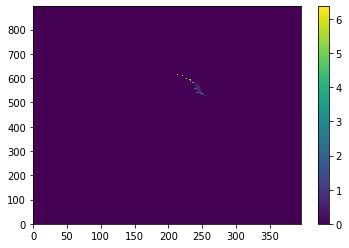

In [14]:
colours = plt.pcolormesh(oiltime)
plt.colorbar();

(200.0, 320.0)

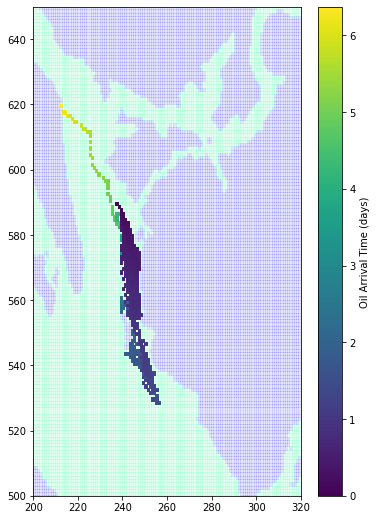

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask, cmap='winter_r', alpha=0.1)

C = ax.pcolormesh(
     oiled,
    zorder=2, vmin=0,
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Oil Arrival Time (days)')
ax.set_ylim(500, 650)
ax.set_xlim(200, 320)

In [27]:
beachtime = (np.array(testfile_a.Beaching_Time - testfile_a.Beaching_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24.

In [28]:
beached = np.ma.masked_array(beachtime, beachtime == 0)


(200.0, 320.0)

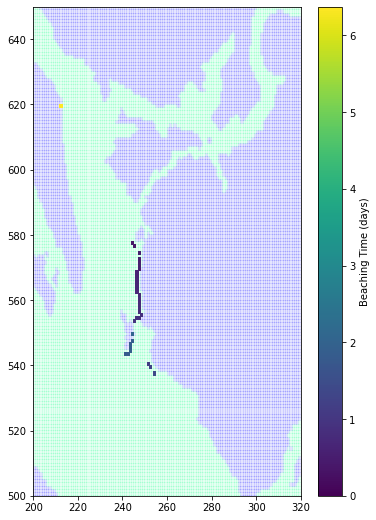

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask, cmap='winter_r', alpha=0.1)

C = ax.pcolormesh(
     beached,
    zorder=2, vmin=0,
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Beaching Time (days)')
ax.set_ylim(500, 650)
ax.set_xlim(200, 320)

### Yes oil arrival time looks good.

***

# Beaching Time

In [4]:
minoil = 5 # litres per grid cell

In [5]:
#set up bootstrap

In [6]:
mcsize = 49
beaching_time = np.zeros((mcsize+1, 896, 396))
rng = np.random.default_rng()

In [7]:
pois = rng.poisson(1, mcsize)
pois

array([2, 1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 3, 1, 2, 0, 0, 1, 1, 2, 0, 0,
       1, 1, 0, 2, 1, 0, 2, 2, 3, 0, 0, 0, 3, 1, 0, 1, 2, 0, 2, 1, 1, 1,
       2, 1, 1, 0, 2])

In [29]:
A = np.array([[2, 2], [2, 2]])
B = np.array([1, 2, 3])
C = np.broadcast_to(A, [3, 2, 2])
D = np.broadcast_to(B, [2, 2, 3])
C*D.transpose()

array([[[2, 2],
        [2, 2]],

       [[4, 4],
        [4, 4]],

       [[6, 6],
        [6, 6]]])

In [80]:
beaching_time = np.zeros((mcsize+1, 896, 396))
beachpresence = np.zeros((896, 396))
beaching_oil = np.zeros((mcsize+1, 896, 396))
count = 0
for filename in glob.glob(directory+'results/*/Lagrangian*.nc')[0:3]:
    print ('in')
    with xr.open_dataset(filename) as data:
        count = count + 1
        pois = rng.poisson(1, mcsize)
        beachtime = (np.array(data.Beaching_Time - data.Beaching_Time.min())
              ) /  np.timedelta64(1, 's') /3600./24.
        beached = (beachtime > 0) & (data.Beaching_Volume > minoil/1000.)
        beach_oil = np.log(data.Beaching_Volume + eps) * beached
        beachpresence = beachpresence + beached
        beachtime = beachtime * beached
        beaching_time[0] =  beaching_time[0] + beachtime
        beaching_time[1:] = beaching_time[1:] + (np.broadcast_to(beachtime, (mcsize, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize)).transpose()) 
        beaching_oil[0] = beaching_oil[0] + beach_oil
        beaching_oil[1:] = beaching_oil[1:] + (np.broadcast_to(beach_oil, (mcsize, 896, 396)) 
                                                 * np.broadcast_to(pois, (396, 896, mcsize)).transpose()) 
        print (count)

in
1
in
2
in
3


In [34]:
# Good if good to half a day or 15% of beaching time
absol = 0.5
perol = 0.15
eps = 1e-7

In [81]:
beachpresence.max()

<xarray.DataArray 'Beaching_Volume' ()>
array(2.)

In [82]:
ma_beaching_time = np.ma.masked_array(beaching_time[0]/(beachpresence + eps), beachpresence == 0)
den = np.minimum(np.array(beachpresence) + eps, mcsize)
beached_ste = np.std(beaching_time, axis=0, ddof=1) / np.sqrt(den)
beached = np.ma.masked_array(beaching_time[0], (beachpresence <= 1) | (
    (beached_ste/(beachpresence+eps) > absol) & (beached_ste > perol*beaching_time[0]))) 

In [85]:
print (beaching_oil.shape)

(50, 896, 396)


In [86]:
ma_beach_oil = np.ma.masked_array(beaching_oil[0]/(beachpresence + eps), beachpresence == 0)
den = np.minimum(np.array(beachpresence) + eps, mcsize)
beachoil_ste = np.std(beaching_oil, axis=0, ddof=1) / np.sqrt(den)
beachedoil = np.ma.masked_array(beaching_oil[0], (beachpresence <= 1) | (
    (beachoil_ste/(beachpresence+eps) > absol) & (beachoil_ste > perol*beaching_oil[0]))) 

In [72]:
# look at what I should be dividing by

tmean = np.zeros(50)
for ms in range(50):
    den = np.minimum(np.array(beachpresence) + eps, ms)
    beached_ste = np.std(beaching_time[0:ms], axis=0, ddof=1)/np.sqrt(den)
    tmean[ms] = beached_ste.mean()

/home/allen/venvs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/allen/venvs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/allen/venvs/jupyter/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


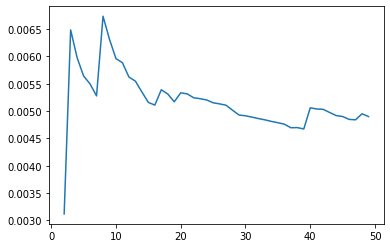

In [73]:
plt.plot(tmean);

In [71]:
np.minimum(np.array(beachpresence), 50)
print (den.max())

2.0


In [78]:
ma_beaching_time.count()

446

In [79]:
beached.count()

53

In [32]:
beachpresence[520, 273].item()

4.0

In [33]:
beaching_time[:, 520, 273] / beachpresence[520, 273].item()

array([2.80208333, 0.97916667, 8.15625   , 4.08333333, 3.59375   ,
       1.58333333, 2.80208333, 1.88541667, 3.10416667, 2.44791667,
       4.4375    , 2.80208333, 0.        , 3.83333333, 2.5       ,
       2.98958333, 3.64583333, 2.98958333, 2.01041667, 2.3125    ,
       0.97916667, 2.80208333, 2.3125    , 4.13541667, 1.52083333,
       2.125     , 1.39583333, 4.625     , 1.77083333, 0.79166667,
       0.79166667, 0.60416667, 2.5       , 1.58333333, 4.02083333,
       2.5       , 1.28125   , 3.10416667, 2.5       , 2.125     ,
       2.80208333, 0.97916667, 3.21875   , 0.        , 2.3125    ,
       3.70833333, 2.26041667, 2.5       , 5.97916667, 0.        ])

1.4970889529516564
0.8554794016866609
2.8020832632812516


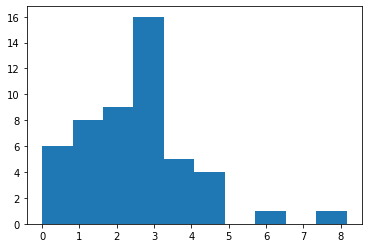

In [36]:
plt.hist(beaching_time[0:, 520, 273]/(beachpresence[520, 273].item() + eps))
print (np.std(beaching_time[:, 520, 273]/beachpresence[520, 273].item(), axis=0, ddof=1))
print (beached_ste[520, 273])
print (ma_beaching_time[520, 273])

In [76]:
ma_beached_ste = np.ma.masked_array(beached_ste, beached_ste == 0)

-- --
[2.625 0.    6.875 0.5   5.75  2.    0.5   8.5   2.625 3.125 0.    2.125
 0.    3.625 3.125 0.    7.375 4.25  2.125 6.375 0.5   4.75  0.5   0.5
 4.75  0.5   0.5   2.125 2.125 0.    1.    1.    1.5   0.5   0.    1.5
 2.625 4.25  0.5   8.5   0.    5.25  2.125 2.125 0.    2.125 4.25  6.875
 2.125 3.625]


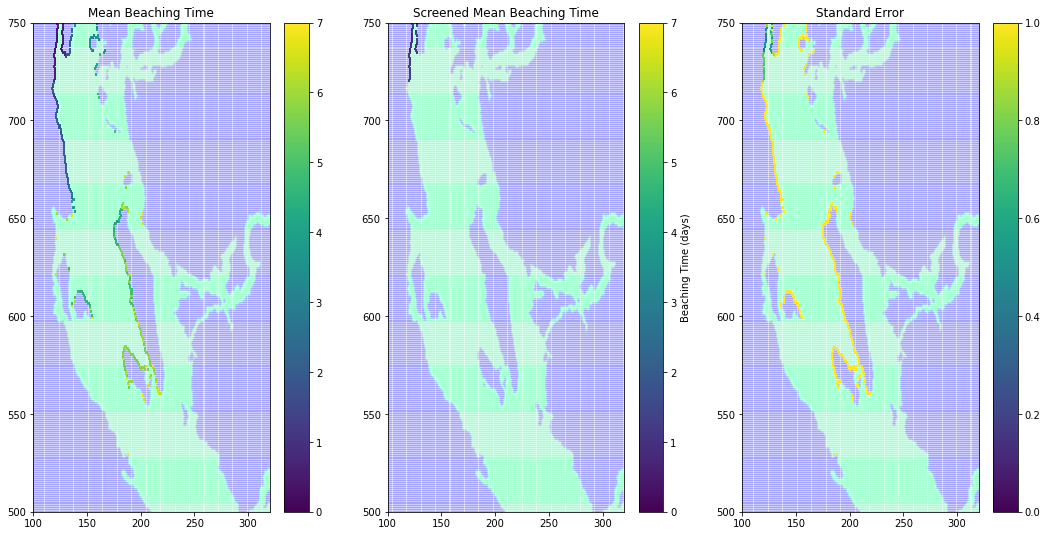

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(500, 750)
    ax.set_xlim(100, 320)

C = axs[0].pcolormesh(
     ma_beaching_time,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[0]);    
axs[0].set_title('Mean Beaching Time')
    
C = axs[1].pcolormesh(
     beached,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')
axs[1].set_title('Screened Mean Beaching Time')

C = axs[2].pcolormesh(
     ma_beached_ste,
    zorder=2, vmin=0, vmax=1
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Standard Error')

print (beached[520, 273], ma_beached_ste[520, 273])
print (beaching_time[:, 750, 122] )

More gaps when I use 25 litres as well as stderr < 15% of signal or < 0.5 days but still pretty good signal throughout the region where we actually have spills

Note that I am now down to 5 L

# Beaching Presence

In [27]:
beaching_presence = np.zeros((mcsize+1, 896, 396))
beachPrescount = 0
for filename in glob.glob(directory+'results/*/Lagrangian*.nc'):
    with xr.open_dataset(filename) as data:
        pois = rng.poisson(1, mcsize)
        beached = data.Beaching_Volume > minoil/1000.
        beaching_presence[0] =  (beaching_presence[0] * beachPrescount + beached) / (beachPrescount + 1)
        for ii in range(1, mcsize):
            beaching_presence[ii] = (beaching_presence[ii] * beachPrescount + beached * pois[ii-1]) / (beachPrescount + 1)
        beachPrescount = beachPrescount + 1

In [53]:
absol = 1e-3
perol = 0.15
ma_beaching_pres = np.ma.masked_array(beaching_presence[0], beaching_presence[0] == 0)
beachPres_ste = np.std(beaching_presence, axis=0, ddof=1) / np.sqrt(mcsize)
beachPok = np.ma.masked_array(beaching_presence[0], (beaching_presence[0] == 0) | (
    (beachPres_ste > absol) & (beachPres_ste > perol*beaching_presence[0]))) 

In [54]:
ma_beachPres_ste = np.ma.masked_array(beachPres_ste, beachPres_ste == 0)

0.008310249307479228 0.0006596824325021688


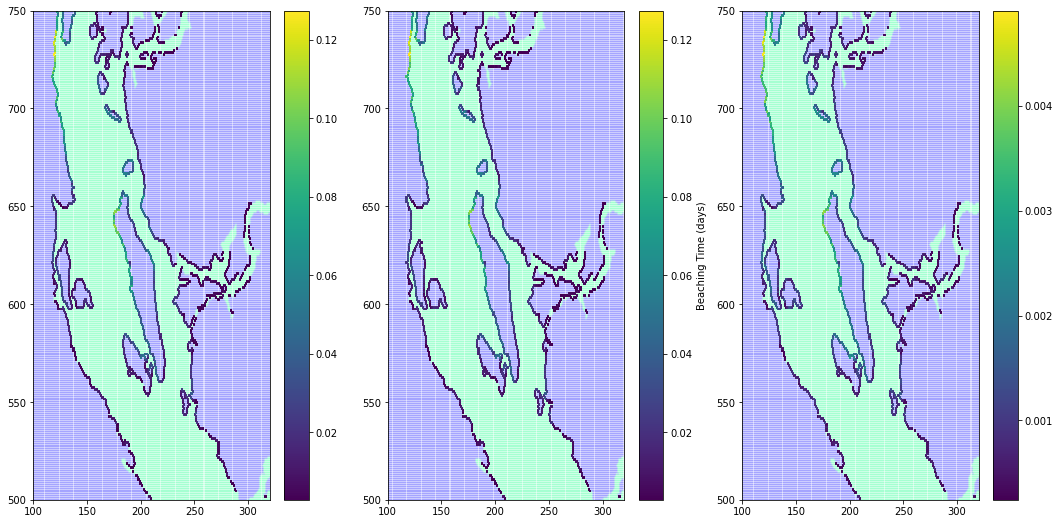

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(500, 750)
    ax.set_xlim(100, 320)

C = axs[0].pcolormesh(
     ma_beaching_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[0]);    
    
C = axs[1].pcolormesh(
     beachPok,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')

C = axs[2].pcolormesh(
     ma_beachPres_ste,
    zorder=2, #vmin=0, vmax=1
)
cb = fig.colorbar(C, ax=axs[2]);

print (beaching_presence[0, 520, 273], ma_beachPres_ste[520, 273])

In [ ]:
ma_beached_ste = np.ma.masked_array(beached_ste, beached_ste == 0)

-- --
[2.625 2.625 0.5   0.    0.    5.25  3.125 0.    4.25  0.5   0.5   2.125
 2.125 2.125 2.125 0.    2.125 2.625 2.625 2.125 2.625 0.5   2.125 1.
 1.    4.75  4.25  0.5   1.    4.75  1.    6.375 2.625 2.625 5.25  2.625
 2.625 0.    1.    2.625 0.5   0.    3.125 3.625 0.    0.5   0.    1.
 1.    0.5  ]


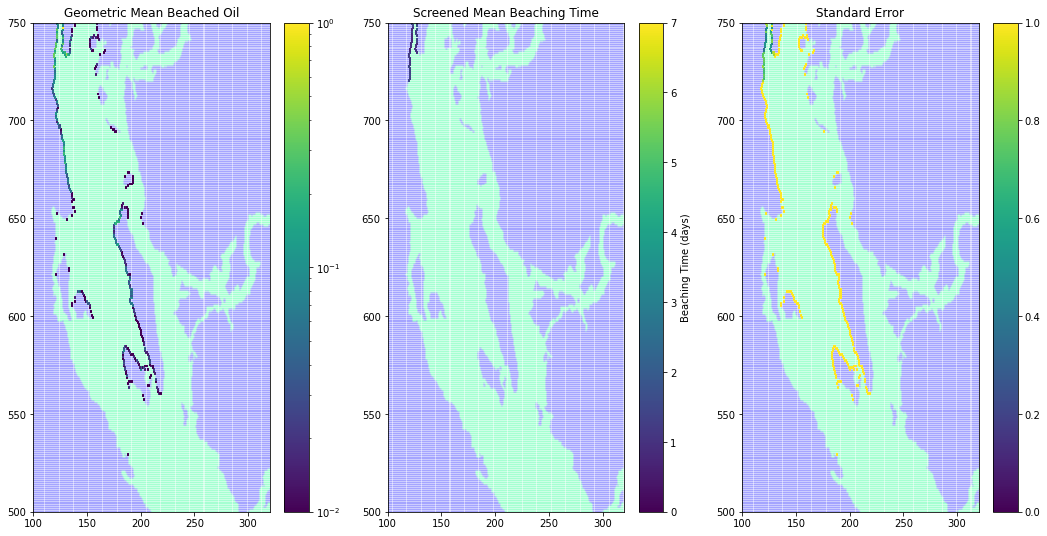

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='winter_r', alpha=0.1)
    ax.set_ylim(500, 750)
    ax.set_xlim(100, 320)

C = axs[0].pcolormesh(
     np.exp(ma_beach_oil), norm=colors.LogNorm(vmin=0.01, vmax=1),
    zorder=2, 
)
cb = fig.colorbar(C, ax=axs[0]);    
axs[0].set_title('Geometric Mean Beached Oil')
    
C = axs[1].pcolormesh(
     beached,
    zorder=2, vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')
axs[1].set_title('Screened Mean Beaching Time')

C = axs[2].pcolormesh(
     ma_beached_ste,
    zorder=2, vmin=0, vmax=1
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Standard Error')

print (beached[520, 273], ma_beached_ste[520, 273])